## LRP

In [137]:
# Biblioteki

from PIL import Image
import torchvision.transforms as transforms
import torch

from zennit.rules import Epsilon
from zennit.composites import EpsilonPlusFlat, EpsilonAlpha2Beta1Flat, DeconvNet, GuidedBackprop, BetaSmooth, ExcitationBackprop
from zennit.attribution import Gradient

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

from util.cnn_parameters import IMG_HEIGHT, IMG_WIDTH, TEST_IMAGES_PATH
from util.torch_architecture import CNN
from zennit.image import imgify, imsave


INPUT_IMG_FILE = "input.png"
RELEVANCE_IMG_FILE = "relevance.png"


### Załadowanie modelu


In [138]:
model = CNN()
model.load_state_dict(torch.load("cats_dogs_cnn.pth", map_location=torch.device("cpu")))
model.eval()

C:\Users\magma\AppData\Local\Temp\ipykernel_24804\529079767.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cats_dogs_cnn.pth", map_loc

CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.25, inplace=False)
    (15): Conv2d(128, 256, kernel_size=(3, 3), stride=

### Image Preprocessing

In [ ]:

def prepare_image(image_path):

    image = Image.open(image_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
        transforms.ToTensor(),
    ])

    input_image = transform(image).unsqueeze(0)

    print("Input image shape:", input_image.shape)  # [1, 3, 128, 128]
    return input_image


Input image shape: torch.Size([1, 3, 128, 128])


### LRP

In [ ]:
# Metoda LRP
def LRP_method(pytorch_model, input_image, composite = EpsilonPlusFlat(epsilon=1e-6)):

    pytorch_model.eval()

    with Gradient(pytorch_model, composite=composite) as attributor:
        _, relevance = attributor(input_image)

    return relevance

def plot_lrp(input_image, relevance):
    for _, inp in enumerate(input_image):
        imsave(INPUT_IMG_FILE, inp.detach())

    absrel = relevance.abs().sum(1)
    imsave(RELEVANCE_IMG_FILE, absrel[0], vmin=0, vmax=absrel[0].amax())
    image = imgify(absrel[0], vmin=0, vmax=absrel[0].amax())

    image1 = mpimg.imread(INPUT_IMG_FILE)
    image2 = mpimg.imread(RELEVANCE_IMG_FILE)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image1)
    axes[0].axis('off')
    axes[0].set_title("Original Image")

    axes[1].imshow(image2)
    axes[1].axis('off')
    axes[1].set_title("LRP Heatmap")

    plt.tight_layout()
    plt.show()

    os.remove(INPUT_IMG_FILE)
    os.remove(RELEVANCE_IMG_FILE)



In [ ]:

composites = [
    EpsilonPlusFlat(epsilon=1e-6),
    EpsilonAlpha2Beta1Flat(epsilon=1e-6)
]

Input image shape: torch.Size([1, 3, 128, 128])


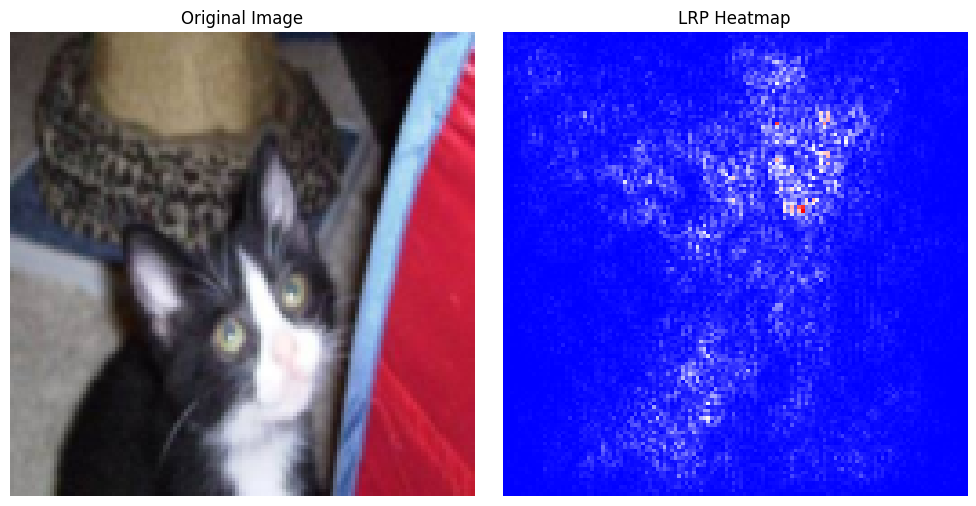

In [ ]:
image_path = TEST_IMAGES_PATH + "\\8.jpg"
input_image = prepare_image(image_path)

comp = EpsilonAlpha2Beta1Flat(epsilon=1e-6)
relevance = LRP_method(model, input_image, composite=comp)

plot_lrp(input_image, relevance)